# ORIE 5355/INFO 5370 HW 2: Recommendation systems

 - Name: Atmika Pai
 - Net-id: aap253
 - Date: Oct 1, 2024
 - Late days used for this assignment: 0
 - Total late days used (counting this assignment): 0
 - People with whom you discussed this assignment: 0

After you finish the homework, please complete the following (short, anonymous) post-homework survey: https://forms.gle/toCDaWjfiEq5hYv76 and include the survey completion code below.

### Question 0 [1 points]
<font color='green'> Survey completion code: hw22022xyz

We have marked questions in <font color='green'> blue </font>. Please put answers in black (do not change colors). You'll want to write text answers in "markdown" mode instead of code. In Jupyter notebook, you can go to Cell > Cell Type > Markdown, from the menu. Please carefully read the late days policy and grading procedure [here](https://orie5355.github.io/Fall_2021/assignments/). 

# Conceptual component

Go through the "Algorithms tour" [here](https://algorithms-tour.stitchfix.com/). It's a great view of the combination of algorithms used by a modern e-commerce company. 

<font color='green'> 1) How do they use a combination of "latent" factors and explicit features to gain the benefits of collaborative filtering (matrix factorization) while not being susceptible to cold start issues?

Stitchfix uses standard collaborative filtering algorithms, but enhances them with explicit data from both clients' self-descriptions, clothing attributes, and style profile. Stitch Fix also infers latent (unstated) features of both clients and styles from available structured and/or unstructured data to improve performance. For example, they determine where a client's size preference falls on a spectrum (e.g., smallish medium to largish medium) based on fit feedback and purchase history. These latent features are then incorporated into their mixed-effects models and other algorithms. Both the explicit features and "latent" factors help address the cold start problem.  

I thought it was interesting that Stitchfix integrates clients' Pinterest moodboards and written feedback into its recommender process to identify items in their inventory that are visually or verbally similar to the client's preferences. They use neural networks and natural language processesing to achieve this. 

<font color='green'> 2) How do they match clients with human stylists who make the final decision? Does it remind you of anything we learned in class?

They calculate a match score between each available stylist and each client requesting a shipment. This score is based on the history between the client and stylist (if any) and the affinities between the client's stated and latent style preferences and those of the stylist. The stylist assignment problem is then solved as an optimization problem, similar to their warehouse assignment algorithm. This process is only run on those clients awaiting shipments and is run frequently to account for the stylists' varying queue sizes.

It reminded me of the curated top 10 lists that we talked about in class as a preamble to recommender systems, but this is more a personalized version of that.

<font color='green'> 3) How do they manage their inventory to ensure that they have enough items that future customers will want?

Stitchfix keeps track of the "state" of each client at each point in time, which helps them infer the clients needs. (Example of a state: Is a client in a phase of building up their wardrobe after a life change or simply wanting to try a new dad?) Once they can define clients' states and detect clients' transitions between them, they develop state transition matrices and Markov chain models that allow them to study system-level effects.

What is interesting is that Stitch Fix also uses a genetic algorithm-inspired approach to design new styles for their exclusive brands. They recombine attributes from existing styles, model the likelihood of success for new attribute combinations, and work with human designers to refine and produce new styles. This helps them continually improve their inventory to meet client preferences. 

They also use Markov chain models to anticipate future demand.

# Programming component

## Helper code

In [1]:
import numpy as np
import pandas as pd
import os, sys, math
import matplotlib.pyplot as plt
import pickle
def load_pickle(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

def load_ratings_and_factors(type_name = 'rating_all_zero'):
    # ratings = load_pickle('data/{}_ratings'.format(type_name))
    book_vectors = load_pickle('data/{}_dict_book_factor'.format(type_name))
    user_vectors = load_pickle('data/{}_dict_reader_factor'.format(type_name))
    return book_vectors, user_vectors

In this homework, we are giving you trained user and book item vectors using a GoodReads dataset. Goodreads is a social cataloging website that allows individuals to search its database of books, annotations, quotes, and reviews. There are multiple types of interactions that a user can have with a book: add books to a list of books they intend to read ("short-list" the book), indicate they have read books before, and review books they have read. A user may have interacted with a book, even if they never left any explicit rating or review. Ratings actually left by users range from 1 to 5 (stars), with 5 being the most positive and 1 being the most negative.

Here, we work with multiple types of data that capture interactions between books and users as training data for a recommendation system. For each "type" of rating data, we give you the raw ratings data, as well as user and item vectors trained using a Python package (https://berkeley-reclab.github.io/) that implements matrix factorization in cases where there are missing entries in a matrix. The "ratings" data is in a "sparse matrix"/dictionary format, meaning that the dictionary keys are of the kind (user, item), and the dictionary value is the corresponding value. Not all pairs are in the matrix, indicating that that value is missing or at its default value. 

There are 2 types of rating/interaction data:
  
 - `Rating_all_missing_zero`: Numeric values more than 0 indicate the star ratings given. Missing values are replaced with 0's, so that there are no missing ratings. In another word, if a user has not left any reviews for a book, we assume that the user would rate the book 0 star.
 
 - `Rating_interaction_zero`: Numeric values more than 0 indicate the ratings given. Now, we replace missing values with 0's, _only if the user interacted with that book in the past_. In other words, if a user has not left any reviews for a book *and* has interacted with the book, we assume that the user would rate the book 0 star. Note that after such replacement, we would still get some missing values, since not all users have interacted with all the books.

In [2]:
book_vectors_allmissing0, user_vectors_allmissing0 = load_ratings_and_factors(type_name = 'rating_all_zero')
book_vectors_interact0, user_vectors_interact0 = load_ratings_and_factors(type_name = 'rating_interaction_zero')

In [3]:
def get_shapes_and_ranges(book_vectors, item_vectors):
    print(np.shape(book_vectors), np.shape(item_vectors))

In [4]:
get_shapes_and_ranges(book_vectors_allmissing0, user_vectors_allmissing0)
get_shapes_and_ranges(book_vectors_interact0, user_vectors_interact0)

(200, 10) (1000, 10)
(200, 10) (1000, 10)


## Problem 1: Predictions and recommendations with different data types

### 1a) What do different data types mean?

<font color='green'> What is `Rating_interaction_zero` trying to capture -- why would we fill in books that someone interacted with but did not rate as a 0? (Hint: connect to conceptual reading from HW1). Answer in no more than 3 sentences. 

The rating_interaction_zero accounts for situations in which users interacted with a book and did not give it a rating. 

In the eBay paper from hw1, we observed that there was a positive skew since many bad experiences go unreported. The rating_interaction_zero addresses this issue by capturing instances where a user interacted with a book where they perhaps did not explicitly like it, resulting in no rating being submitted. 

<font color='green'> What are some potential problems you see with using `Rating_all_missing_zero` for recommendations? Answer in no more than 3 sentences.
    
    

The rating_all_missing_zero doesn't consider whether the user has interacted with the book or not. Therefore, the zero value is misleading if the user has not interacted with the book.

### 1b) Generating predictions

<font color='green'> Fill in the following function that takes in a user matrix (where each row is 1 user vector) and an item matrix (where each row is 1 item vector), and returns a matrix of predicted ratings for each user and item, where each entry is associated with the corresponding user (row number) and item (column number)

In [5]:
def get_predictions(user_vectors, book_vectors):
    return user_vectors @ book_vectors.T

<font color='green'> Output the predictions for first 10 items for the first user, using each of the 2 data types.

For example, the predictions for one of the data types are:

Ratings for first 10 items, Ratings_all_missing_zero:

[ 0.08   0.29   0.063  1.57  -0.186  0.055  0.011 -0.088 -0.895 -0.012]

In [6]:
predictions_allmissing0 = get_predictions(user_vectors_allmissing0, book_vectors_allmissing0)
predictions_interact0 = get_predictions(user_vectors_interact0, book_vectors_interact0)

predictions_allmissing0[0][:10].round(3)

array([ 0.08 ,  0.29 ,  0.063,  1.57 , -0.186,  0.055,  0.011, -0.088,
       -0.895, -0.012])

In [44]:
predictions_interact0[0][:10].round(3)

array([-1.009,  4.167, -0.919, -0.302, -2.526, -0.189, -3.081, -0.537,
       -1.186, -1.218])

<font color='green'> Do a scatterplot of the predicted rating for two data types. (Each dot represents one user and one book, with X axis being predicted ratings using `Rating_interaction_zero` data and Y axis being predicted rating using `Rating_all_missing_zero` ratings). Describe what you see in no more than 2 sentences. 

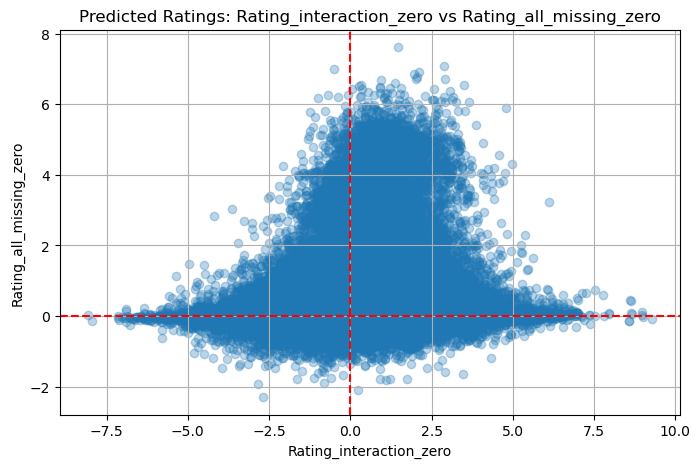

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(predictions_interact0, predictions_allmissing0, alpha=0.3)
plt.title('Predicted Ratings: Rating_interaction_zero vs Rating_all_missing_zero')
plt.xlabel('Rating_interaction_zero')
plt.ylabel('Rating_all_missing_zero')
plt.axhline(0, color='red', linestyle='--')
plt.axvline(0, color='red', linestyle='--')
plt.grid()
plt.show()

The majority of data points are clustered around the origin, forming an asymmetrical bell-shaped pattern, with a higher distribution of positive values for rating_interaction_zero illustrating the positive skew I had mentioned in question 1a.

As rating_interaction_zero take on more extreme values, the variation in rating_all_missing_zero increases, showing less consistency at the extremes.

### 1c) From predictions to recommendations (without capacity constraints)

<font color='green'> Fill in the following function that takes in the matrix of predicted ratings for each user and item, and returns a dictionary where the keys are the user indices and the values are a list of length "number_top_items" indicating the recommendations given to that user

In [8]:
def get_recommendations_for_each_user(predictions, number_top_items = 10):
    recommendations = {}
    for user in range(predictions.shape[0]):
        user_ratings = predictions[user, :]
        top_item_indices = np.argsort(-user_ratings)[0:number_top_items]
        recommendations[user] = top_item_indices.tolist()
    return recommendations

<font color='green'> Output the recommendations for the first user, using each of the 2 data types.

For example, from the `Ratings_all_missing_zero` dataset, you should get: [57, 55, 56, 81, 50, 78, 58, 86, 77, 96]

In [9]:
recommendations_allmissing0 = get_recommendations_for_each_user(predictions_allmissing0)
recommendations_interact0 = get_recommendations_for_each_user(predictions_interact0)

print("Top recommendations for user 0 using rating_all_zero :", recommendations_allmissing0[0])
print("Top recommendations for user 0 using rating_interaction_zero:", recommendations_interact0[0])


Top recommendations for user 0 using rating_all_zero : [57, 55, 56, 81, 50, 78, 58, 86, 77, 96]
Top recommendations for user 0 using rating_interaction_zero: [166, 53, 1, 111, 170, 74, 182, 37, 73, 52]


<font color='green'> Fill in the following function that takes in the (top 10) recommendations for each user, and outputs a histogram for how often each item is to be recommended. For example, if there are 18 items, and 10 of them were never recommended, 5 of them were recommended once each, and 3 of them were recommended five times each, then you would have bars at 0, 1, and 5, of height 10, 5, and 3, respectively.

In [54]:
from collections import Counter
def show_frequency_histograms(recommendations):
    
    #all recommendations
    all_recommendations = [item for recs in recommendations.values() for item in recs]
    
    
    #frequency of recommendations per item
    item_occurrences = [0] * (max(all_recommendations) + 1)
    frequencies = Counter(all_recommendations)
    for item in frequencies.keys():
        item_occurrences[item] = frequencies[item]
    
    #frequency of items for each freq recommendation
    bars = Counter(item_occurrences)
    
    plt.bar(bars.keys(), bars.values())
    plt.xlabel('Times an item is recommended')
    plt.ylabel('Number of items')
    plt.title('Item Recommendation Frequency Histogram')
    plt.show()

<font color='green'> Show the histograms for both data types. Describe what you observe in no more than 3 sentences. For example, discuss how often is the most recommended item recommended, how that compares to the least recommended items, and what that could mean for recommendations in various contexts. 

recommendations_allmissing0:


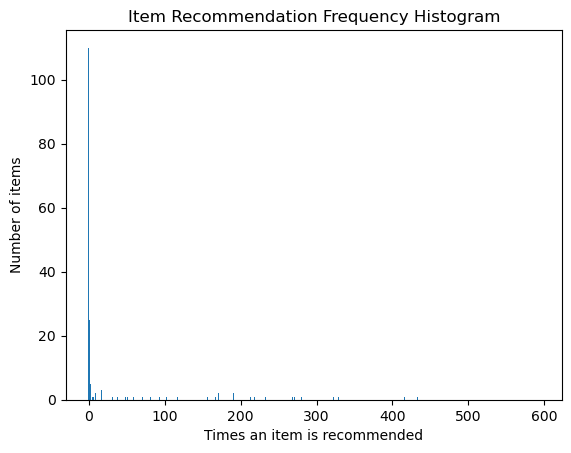

recommendations_interact0:


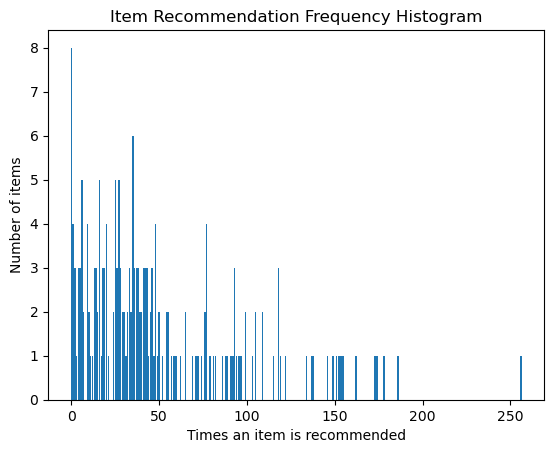

In [55]:
print("recommendations_allmissing0:")
show_frequency_histograms(recommendations_allmissing0)
print("recommendations_interact0:")
show_frequency_histograms(recommendations_interact0)

The histogram for "recommendations_allmissing0" shows a highly skewed distribution, with the most recommended item appearing around 600 times and 100+ items are recommended 0 times. 

In contrast, the "recommendations_interact0" histogram is more evenly distributed, with many items being recommended between 1 and 100 times and ~8 items recommended 0 times. This indicates that this recommendations method offers a wider more diverse selection of items to users.

# Problem 2: Cold start -- recommendations for new users

In this part of the assignment, we are going to ask you to tackle the "cold-start" problem with matrix-factorization based recommendation systems. The above recommendation techniques worked when you had access to past data for reach user, such as interactions or explicit ratings. However, it doesn't work as well when a new user has just joined the platform and so the platform doesn't have any data.  

You should also see a comma-separated values file (user_demographics.csv) that contains basic demographic information on each user. Each row describes one user, and have four attributes: 'User ID', 'Wealth', 'Age group' and 'Location'.

User ID is the unique identifier associated with each user, and it is in the same order as the user_vectors, and in the same indexing as the ratings (be careful about 0 and 1 indexing in Python).

Wealth is a non-negative, normalized value indicating the average wealth of the neighborhood in which the user is, where we normalized it such that each Location has similar wealth distributions. Age group describes the age of the user. Location describes the region that the user is from.

In [56]:
demographics = pd.read_csv("data/user_demographics.csv")
demographics.head()

,User ID,Wealth,Age group,Location
0,1,1.833101,50 to 64,America
1,2,2.194996,18 to 34,America
2,3,2.216195,18 to 34,Europe
3,4,0.838690,50 to 64,Asia Pacific
4,5,2.109313,18 to 34,America


We are now going to pretend that we don't have the personalized ratings/interactions history for the last 100 users, and thus don't have their user vectors. Rather, let's pretend that these are new users to the platform, and you are able to get the above demographics from their browswer cookies/IP address. Now, we're going to try to recommend items for them anyway. For this part, we'll exclusively use the `Rating_interaction_zero` data.

In [57]:
existing_user_vectors = user_vectors_interact0[0:900,:]
existing_user_demographics = demographics.iloc[0:900,:]
new_user_demographics = demographics.iloc[900:,:]

### 2a) Predictions for new users [Simple]

<font color='green'> Fill in the following function that takes in: the demographics of a single new user, the demographics of all the existing users in your platform, and the user vectors of all the existing users, and outputs a 'predicted' user vector for the new user to use until we get enough data for that user. 
    
<font color='green'> For this question, we ask you to use the following simple method to construct the vector for the new user. Each user is classified as "Low" or "High" wealth based on whether their Wealth score is below or above the median of about 1.70. Then, we simply construct a mean user vector for "Low" and "High" wealth, based on the 900 users (take the average vector among users with "Low" and "High" Wealth, respectively.). The correpsonding mean vector is then used for each new user. 

For example, using this method, you should find that the vector for the second user (index "1") is:

array([-0.183, -0.149, -0.141, -0.199, -0.166, -0.272, -0.02 ,  0.137,
       -0.12 ,  0.022])

Note: our answers below are based on the median _not rounded_ to 2 decimal places, i.e., we use the full median to many decimal places.

In [14]:
existing_user_demographics.Wealth.median()

1.7026180771992308

In [15]:
def get_user_vector_for_new_user(new_user, existing_user_demographics, existing_user_vectors):
    wealth_median = existing_user_demographics.Wealth.median()
    
    low_wealth_users = existing_user_vectors[existing_user_demographics.Wealth < wealth_median]
    high_wealth_users = existing_user_vectors[existing_user_demographics.Wealth >= wealth_median]
    
    mean_low_wealth = np.mean(low_wealth_users, axis=0)
    mean_high_wealth = np.mean(high_wealth_users, axis=0)
    
    if new_user['Wealth'] < wealth_median:
        return mean_low_wealth
    else:
        return mean_high_wealth

In [16]:
get_user_vector_for_new_user(new_user_demographics.iloc[1, :], 
                             existing_user_demographics, 
                             existing_user_vectors).round(3)

array([-0.183, -0.149, -0.141, -0.199, -0.166, -0.272, -0.02 ,  0.137,
       -0.12 ,  0.022])

<font color='green'> Output the mean vector predicted for the first user (index 0) in `new_user_demographics`. 

In [17]:
get_user_vector_for_new_user(new_user_demographics.iloc[0, :], 
                             existing_user_demographics, 
                             existing_user_vectors).round(3)


array([ 0.088, -0.207, -0.178, -0.131, -0.089, -0.127, -0.122, -0.427,
       -0.058, -0.106])

<font color='green'> For each of the 100 "new" users, use either of your model to retrieve a user vector for that user, and then your functions from Problem 1 to get predicted ratings and top-10 recommendations. 

Plot a scatterplot between the ratings predicted by the demographic model and the ratings predicted by the full model from Problem 1. Each point in the scatter plot should correspond to one user and one item, and so your scatterplot should have 100*200 points.  

For example, for the first user-item pair (index 0 user, index 0 user), your prediction using the basic demographic should be -0.0011, and using the full model should be 0.3144. So one point in the scatter plot would be (-0.0011, 0.3144).

In [18]:
predictions_demographic = []

for user in range(100):
    predictions_demographic.append(get_predictions(get_user_vector_for_new_user(
                                                 new_user_demographics.iloc[user, :], 
                                                 existing_user_demographics, 
                                                 existing_user_vectors), book_vectors_interact0))
    
    
#np.concatenate does the same thing as flatten but for list of lists    
predictions_demographic = np.concatenate(predictions_demographic)
predictions_full_model = get_predictions(user_vectors_interact0[900:,:], book_vectors_interact0).flatten()

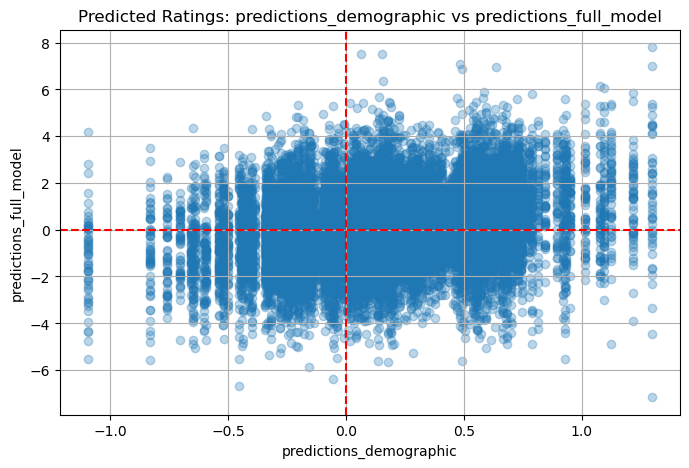

In [19]:
plt.figure(figsize=(8, 5))
plt.scatter(predictions_demographic, predictions_full_model, alpha=0.3)
plt.title('Predicted Ratings: predictions_demographic vs predictions_full_model')
plt.xlabel('predictions_demographic')
plt.ylabel('predictions_full_model')
plt.axhline(0, color='red', linestyle='--')
plt.axvline(0, color='red', linestyle='--')
plt.grid()
plt.show()

<font color='green'> Comment on the above. What is the potential "loss" from using demogprahics since we do not have access to the full data?

The points are widely dispersed, suggesting a weak correlation between the predictions of the two models. This indicates that the demographic model might not capture all the nuances that knowing the history of the user's preferences does. 

Many predictions from the demographic model cluster around zero, while the full model shows a broader range of values. This suggests that relying solely on demographics may lead to less variable/diverse recommendations.


### 2b) [Bonus, 2 points] Predictions for new users [Using KNN or another model]

<font color='green'> Fill in the following function that takes in: the demographics of a single new user, the demographics of all the existing users in your platform, and the user vectors of all the existing users, and outputs a 'predicted' user vector for the new user to use until we get enough data for that user. 
    
<font color='green'> Now, use K nearest neighbors or some other machine learning method, and report the same things as in 2a.
    
<font color='green'> Feel free to prepare data/train a model outside this function, and then use your trained model within the function.

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#preprocessing

age_mapping = {
    '18 to 34': 26,  
    '35 to 49': 42,
    '50 to 64': 57,
    '65+': 70
}

def preprocessing(X):
    X['AgeRangeNumeric'] = X['Age group'].map(age_mapping)
    X = X.drop(columns='Age group')
    
    scaler = MinMaxScaler()
    X['AgeRangeNumeric'] = scaler.fit_transform(X[['AgeRangeNumeric']])
    
    
    df_one_hot = pd.get_dummies(X['Location'], prefix='Location').astype(int)
    
    
    merged_df = pd.merge(X, df_one_hot, 
                     left_index = True, 
                     right_index = True)
    merged_df = merged_df.drop(columns='Location').dropna()
    
    return merged_df

merged_df = pd.merge(preprocessing(existing_user_demographics[["Wealth", "Age group", "Location"]]), 
                     pd.DataFrame(existing_user_vectors), 
                     left_index = True, 
                     right_index = True)

In [21]:
from sklearn.neighbors import KNeighborsRegressor
def get_user_vector_for_new_user_knn(new_user, existing_user_demographics, existing_user_vectors):
    
    new_user2 = preprocessing(new_user.drop(columns='User ID'))
    existing_user_demographics2 = preprocessing(existing_user_demographics[["Wealth", "Age group", "Location"]])
    
    merged_df = pd.merge(existing_user_demographics2, pd.DataFrame(existing_user_vectors), 
                     left_index = True, 
                     right_index = True)
    
    X = merged_df.iloc[:, 0:6]
    y = merged_df.iloc[:, 7:]
    
    knn = KNeighborsRegressor(n_neighbors=5, metric='l2')

    knn.fit(X, y)
    y_pred = knn.predict(new_user2)
    return y_pred

<font color='green'> Output the mean vector predicted for the first user in `new_user_demographics`. 

In [22]:
get_user_vector_for_new_user_knn(new_user_demographics, 
                                 existing_user_demographics, 
                                 existing_user_vectors)[0]

array([-0.65638746, -0.22217478, -0.5220968 ,  0.18592481, -0.22984424,
       -0.15618399, -0.81764814, -0.46030473, -0.40887935])

<font color='green'> Justify your choice of model. If you used K nearest neighbors, then how did you decide upon your distance function? If you used another model, how does that model weight the different demographics in importance (either implicitly or explicitly)?

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X = merged_df.iloc[:, 0:6]
y = merged_df.iloc[:, 7:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

k = 3
knn = KNeighborsRegressor(n_neighbors=k, metric='l2')
knn.fit(X, y)
y_pred = knn.predict(X_test)

print("L2 Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred, multioutput='uniform_average'))
print("L2 R^2 Score:", r2_score(y_test, y_pred, multioutput='uniform_average'))

knn = KNeighborsRegressor(n_neighbors=k, metric='l1')
knn.fit(X, y)
y_pred = knn.predict(X_test)

print("L1 Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred, multioutput='uniform_average'))
print("L1 R^2 Score:", r2_score(y_test, y_pred, multioutput='uniform_average'))

L2 Mean Squared Error (MSE): 0.28419729547680056
L2 R^2 Score: 0.35501813646141306
L1 Mean Squared Error (MSE): 0.2841868130307404
L1 R^2 Score: 0.3550921690234104


L2 norm (Euclidean distance) had a slightly higher R^2 and lower MSE than L1 norm, so I decided to go with the euclidean distance.

# Problem 3: Predictions under capacity constraints

Above, you should have observed that if we just recommend the top items for each user, some items get recommended quite a bit, and many items do not get recommended at all. Here, we are going to ask you to implement recommendations under capacity constraints.

Throughout this part, assume that you only have 5 copies of each item that you recommend, and that you will only recommend 1 item to each user. In other words, you cannot recommend the same item more than 5 times, and so there are exactly 1000 items in stock (representing 200 unique books) for your 1000 users. 

We'll continue exclusively using the "ratings with interaction0" data.

Now, let's assume that users are entering the platform sequentially in order of index. So the index 0 user comes first, index 1 user comes second, etc. 

### 3a) Naive recommendations under capacity constraints

<font color='green'> First, let's pretend that we were naively recommending the predicted favorite item to each user. Of course, with unlimited capacity, each user would be recommended their predicted favorite. With capacity constraints, the favorite items of the users who come in later might already have reached their capacity, and so they have to be recommended an item further down their list. 
    
<font color='green'> Do the following: simulate users coming in sequentially, in order of index. For each user, recommend to them their predicted favorite item that is still available. So the first user will get their favorite item, but the last few users will almost certainly not receive any of their top few predicted items. For each user, keep track of what the rank of the item that they were ultimately recommended was, according to the predicting ranking over items for that user.
    
For example, you'll see that the first user was recommended their favorite item, but the last user was recommended their 129th favorite item. 


<font color='green'> Plot the resulting rankings in 2 ways: 1) A line plot, where the X axis is the user index and the Y axis is the rank of the item that they were recommended. and 2) A histogram of how often each rank shows up. (the X axis is the (binned) rank, and the Y axis is the count of that bin). 

<font color='green'> In all cases, you will plot the rank according to the user's predicted ranking. 

In [24]:
def naive_recommendation(predictions, capacity=5):
    num_users, num_items = predictions.shape
    item_supplies = {i: capacity for i in range(num_items)}
    recommendations = []
    ranks = []

    for user in range(num_users):
        sorted_items = np.argsort(-predictions[user])
        
        for item in sorted_items:
            if item_supplies[item] > 0: #is item available?
                recommendations.append(item) #keep track of recommendation for each user
                item_supplies[item] -= 1 #decrease item supply by 1
                rank = np.where(sorted_items == item)[0][0]+1 #identify the rank of item recommended 
                ranks.append(rank)
                break

    return recommendations, ranks, item_supplies

recommended_item_cc, item_ranks_cc, item_supplies_cc = naive_recommendation(predictions_interact0)

In [25]:
print("Rank of item recommended to first user:", item_ranks_cc[1])
print("Rank of item recommended to last user:", item_ranks_cc[-1])

print("How many items left?", min(item_supplies_cc.values()))
print("All items were recommended based on capacity constraints!")

Rank of item recommended to first user: 1
Rank of item recommended to last user: 129
How many items left? 0
All items were recommended based on capacity constraints!


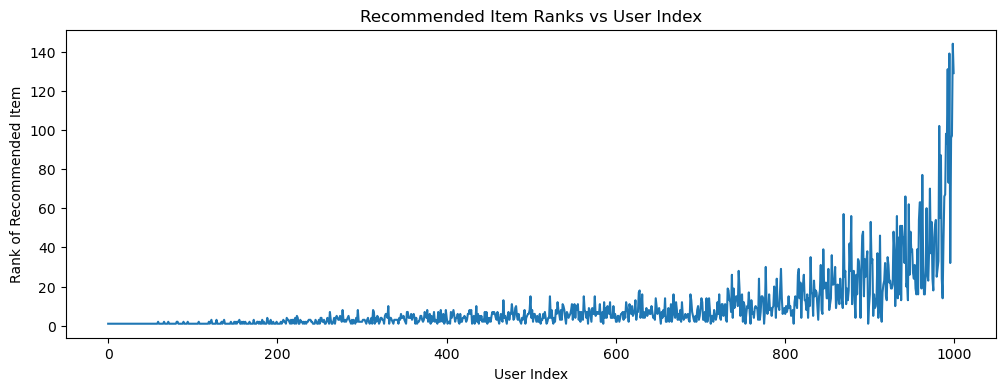

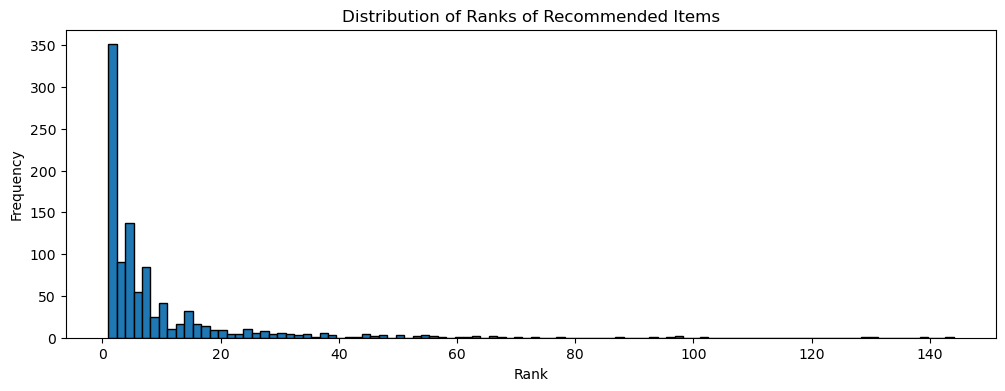

In [26]:
plt.figure(figsize=(12, 4))
plt.plot(range(len(item_ranks_cc)), item_ranks_cc)
plt.title('Recommended Item Ranks vs User Index')
plt.xlabel('User Index')
plt.ylabel('Rank of Recommended Item')
plt.show()

plt.figure(figsize=(12, 4))
plt.hist(item_ranks_cc, bins=100, edgecolor='black')
plt.title("Distribution of Ranks of Recommended Items")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.show()

### 3b) [Bonus -- 4 pts] Optimal recommendations under capacity constraints -- maximum weight matching

[2 points] <font color='green'> Now let's do "optimal" recommendations with capacity, using maximum weight matching. Create the same two plots as above. <font color='green'> Describe what you observe compared to the naive recommendations above. 
    
<font color='green'>We suggest you use the `scipy.optimize.linear_sum_assignment` function. In that case, `np.tile` might also come in handy to create 5 copies of each items.  

In [27]:
from scipy.optimize import linear_sum_assignment

def optimal_recommendation(predictions, capacity=5):
    num_users, num_items = predictions.shape
    
    expanded_predictions = np.tile(predictions, (1, capacity)) #creating five copies of ratings lengthwise
    row_ind, col_ind = linear_sum_assignment(-expanded_predictions)
    
    recommended_items = col_ind % num_items #identifies the item without

    ranks = []
    
    for user in range(num_users):
        sorted_items = np.argsort(-predictions[user])
        rank = np.where(sorted_items == recommended_items[user])[0][0]+1 #identify the rank of item recommended 
        ranks.append(rank)
    
    return recommended_items, ranks

optimal_items, optimal_ranks = optimal_recommendation(predictions_interact0)

In [28]:
print("Highest rank:", max(optimal_ranks))

Highest rank: 86


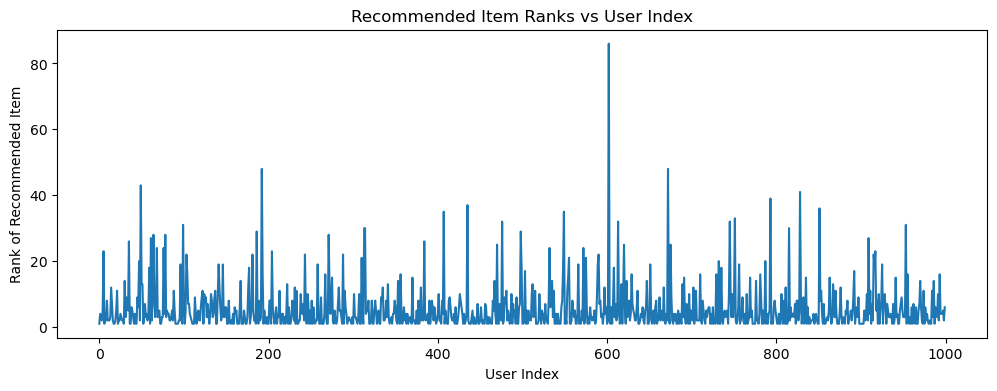

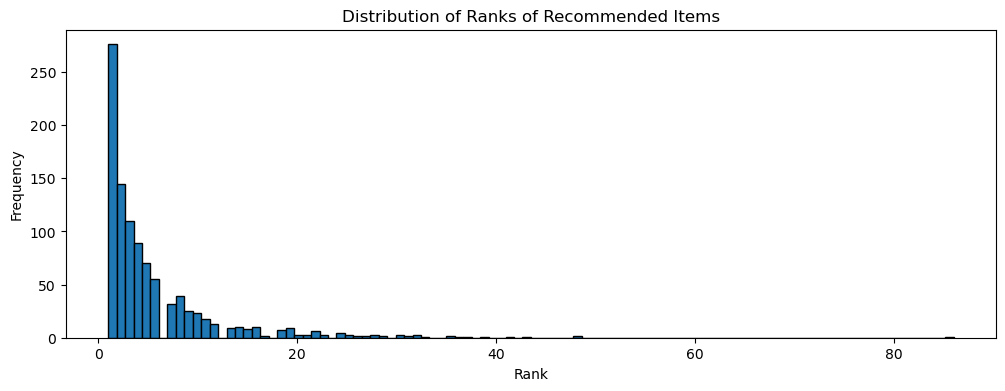

In [29]:
optimal_items, optimal_ranks = optimal_recommendation(predictions_interact0)
plt.figure(figsize=(12, 4))
plt.plot(range(len(optimal_ranks)), optimal_ranks, label='Optimal Recommendation')
plt.title('Recommended Item Ranks vs User Index')
plt.xlabel('User Index')
plt.ylabel('Rank of Recommended Item')
plt.show()

plt.figure(figsize=(12, 4))
plt.hist(optimal_ranks, bins=100, edgecolor='black')
plt.title("Distribution of Ranks of Recommended Items")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.show()

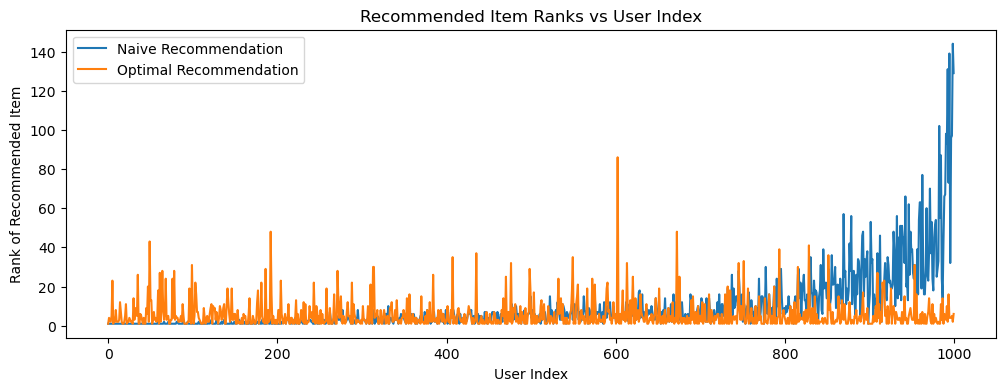

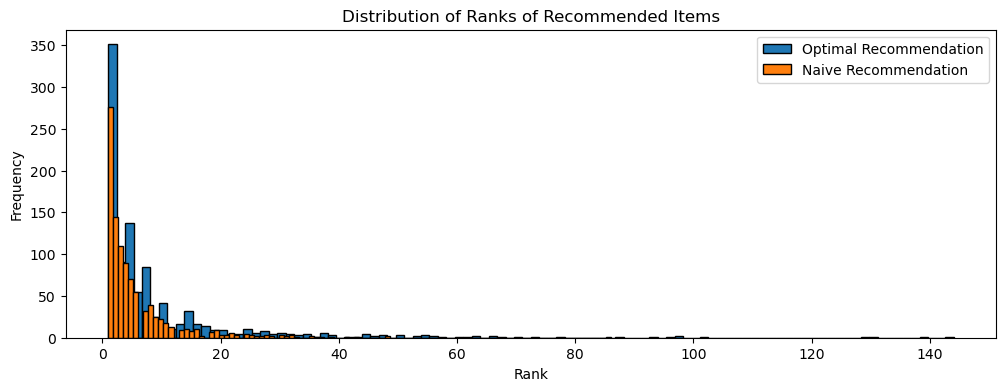

In [30]:
plt.figure(figsize=(12, 4))
plt.plot(range(len(item_ranks_cc)), item_ranks_cc, label='Naive Recommendation')
plt.plot(range(len(optimal_ranks)), optimal_ranks, label='Optimal Recommendation')
plt.title('Recommended Item Ranks vs User Index')
plt.xlabel('User Index')
plt.ylabel('Rank of Recommended Item')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.hist(item_ranks_cc, bins=100, edgecolor='black', label='Optimal Recommendation')
plt.hist(optimal_ranks, bins=100, edgecolor='black', label='Naive Recommendation')
plt.title("Distribution of Ranks of Recommended Items")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.legend()
plt.show()

The naive approach recommends less preferred items to later users, while the maximum weight matching approach recommendeds items within the ~50th rank to majority of users regardless of when the user comes in. This is why the orange line in the graph is more consistent and stable than the blue curve which takes on an exponential curve. 

The optimal approach has a left skew greater than the naive approach, indicating that it is better at providing users with better-ranked items.

[2 points] <font color='green'> Of course, in reality you don't observe all the users at the same time -- they come in one by one, and you need to create a recommendation for the first user before the 50th user shows up. Here's let's pretend that users show up in batches of 100. So the first 100 users at the same time, next 100, etc. In this case, you can do "batched maximum weight matching," where you run maximum weight matching for the first 100 together to determine recommendations. Then, you do the same thing for the next 100 users with the items that are remaining, etc. 
    
<font color='green'> Implement the above, show the same two plots as above, and describe what you observe. Note that this part requires careful attention for how many of each item remain after each round. 

### 3c) Score functions for recommendations under capacity constraints

<font color='green'>Here, we are working with just 200 items and 1000 users, and so batched maximum weight matching is feasible to run. In practice, with millions of items, that  might not be an effective strategy. Now, we ask you to implement the score function approach from class.

<font color='green'> You should normalize the predicted ratings between 0 and 1 so that you are not dividing by a negative or close to 0 average rating before proceeding.
    
<font color='green'> Implement the above and run the same simulation as part 3a, show the same two plots, and describe what you observe.

Note that, as above, you will plot the rank according to the user's predicted ranking, NOT the score function ranking. (Plotting by score function ranking will result in just a straight line where everyone gets their top ranked item, which is incorrect).

<font color='green'> For this part, use the following score function:
    
$$\frac{r_{ij}}{\bar{r_{j}}} \sqrt{C_j} $$

HINT: In your code, for each user $i$ you will:
1. Retrieve the ratings ${r_{ij}}$ for each item $j$. 
2. Normalize each  ${r_{ij}}$  by mean item rating $r_j$ and multiply by the sqrt of the current capacity for that item. 
3. Sort the items by the above modified score, and recommend the best item according to the modified score.

In [38]:
def score_function_recommendation(predictions, capacity=5):
    
    normalized_predictions = (predictions - predictions.min()) / (predictions.max() - predictions.min())
    rij = pd.DataFrame(normalized_predictions)
    mean_item_ratings = rij.mean(axis=0)
    scores = rij/mean_item_ratings*np.sqrt(capacity)

    num_users, num_items = predictions.shape
    item_supplies = {i: capacity for i in range(num_items)}
    recommendations = []
    ranks = []

    for user in range(num_users):
        sorted_items = np.argsort(-scores.T[user])

        for item in sorted_items:
            if item_supplies[item] > 0: #is item available?
                recommendations.append(item) #keep track of recommendation for each user
                item_supplies[item] -= 1 #decrease item supply by 1
                rank = np.where(sorted_items == item)[0][0]+1 #identify the rank of item recommended 
                ranks.append(rank)
                break
                
    return recommendations, ranks 

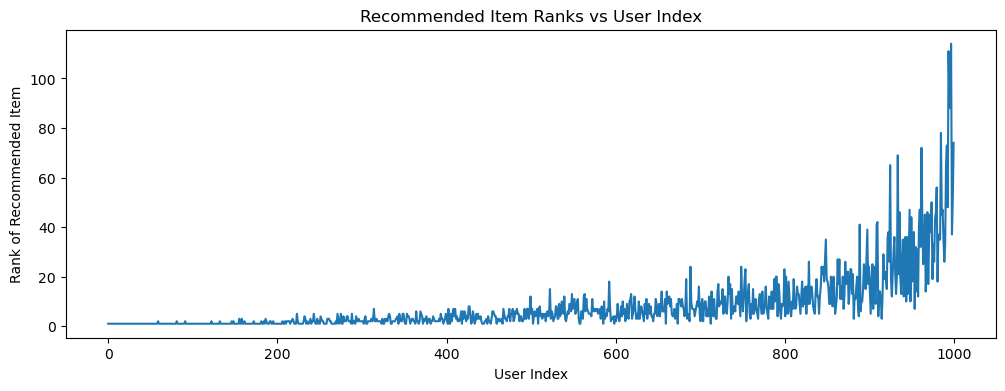

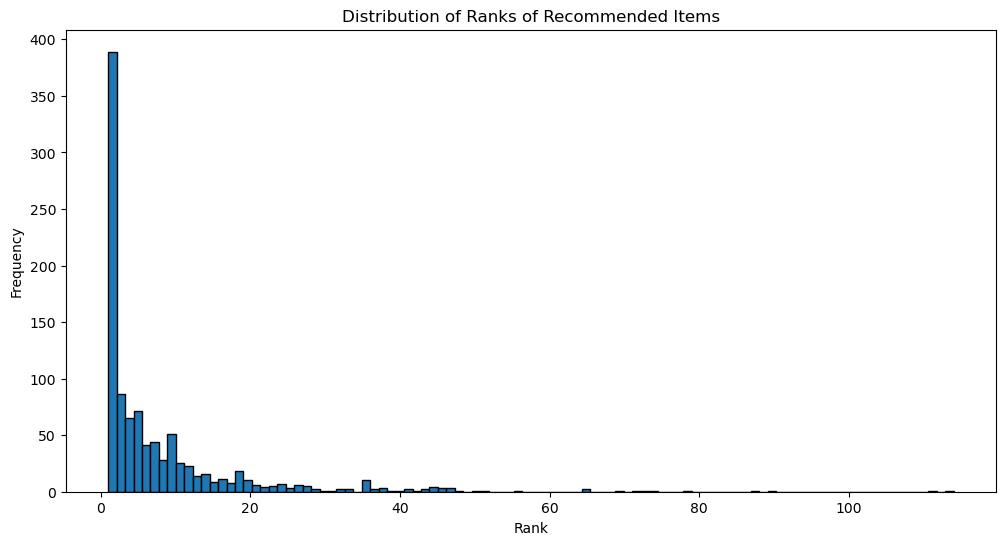

In [39]:
score_method_recommended_items, score_method_item_ranks = score_function_recommendation(predictions_interact0)
plt.figure(figsize=(12, 4))
plt.plot(range(len(score_method_item_ranks)), score_method_item_ranks)
plt.title('Recommended Item Ranks vs User Index')
plt.xlabel('User Index')
plt.ylabel('Rank of Recommended Item')
plt.show()


plt.figure(figsize=(12, 6))
plt.hist(score_method_item_ranks, bins=100, edgecolor='black')
plt.title('Distribution of Ranks of Recommended Items')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.show()

In [40]:
print("Highest rank:", max(score_method_item_ranks))

Highest rank: 114


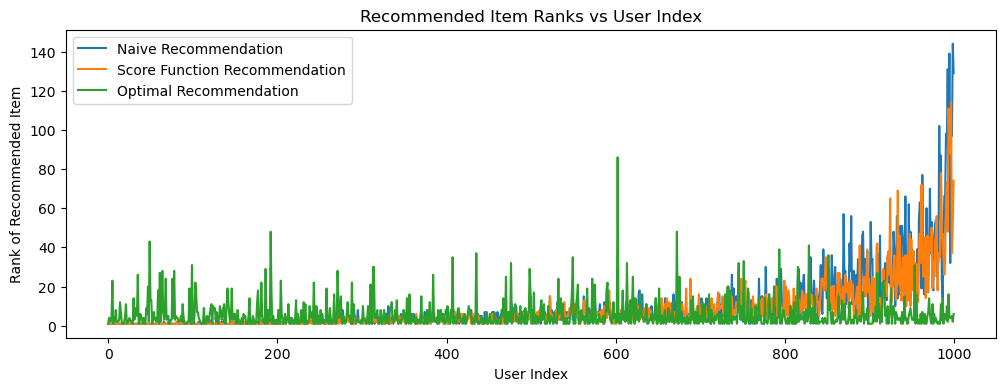

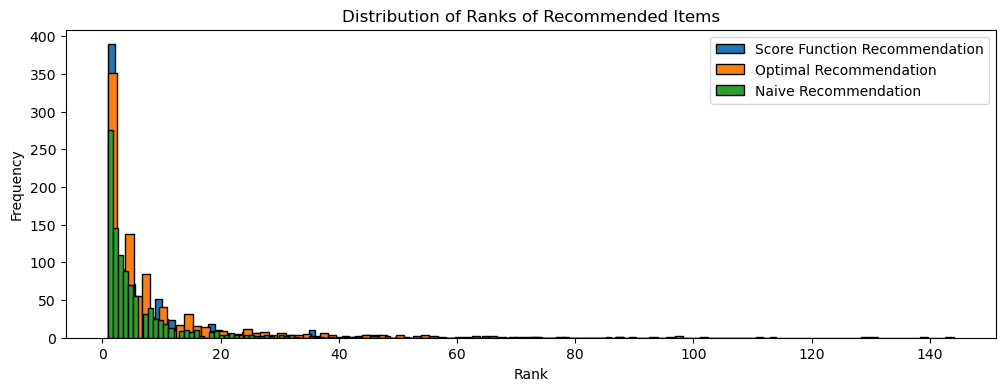

In [41]:
plt.figure(figsize=(12, 4))
plt.plot(range(len(item_ranks_cc)), item_ranks_cc, label='Naive Recommendation')
plt.plot(range(len(score_method_item_ranks)), score_method_item_ranks, label='Score Function Recommendation')
plt.plot(range(len(optimal_ranks)), optimal_ranks, label='Optimal Recommendation')
plt.title('Recommended Item Ranks vs User Index')
plt.xlabel('User Index')
plt.ylabel('Rank of Recommended Item')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.hist(score_method_item_ranks, bins=100, edgecolor='black', label='Score Function Recommendation')
plt.hist(item_ranks_cc, bins=100, edgecolor='black', label='Optimal Recommendation')
plt.hist(optimal_ranks, bins=100, edgecolor='black', label='Naive Recommendation')
plt.title("Distribution of Ranks of Recommended Items")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.legend()
plt.show()

The score function approach is similar to the naive approach in that later users receive less preferred items. 

The optimal approach has a left skew greater than the naive and optimal approach, indicating that it is better at providing users with better-ranked items. The score function ensures higher-rank recommendations to users more than the optimal and naive approach. 

Comment for entire homework: In this homework, we haven't been careful with what is "training" data and what is "test" data. For example, in 3c, you're using average ratings from customers who haven't shown up yet in your simulation. In Problem 2, when training the user/book vectors we used data from customers that we are then pretending we haven't seen data from. In practice, and for the class project, you should be more careful. Such train/test/validation pipelines should be a core part of what you learn in machine learning classes. 